In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import librosa


In [3]:
print(tf.__version__)


2.18.0


In [4]:
import librosa
import tensorflow as tf

def preprocess_audio(file_path):
    waveform, sample_rate = librosa.load(file_path, sr=16000)
    waveform = tf.convert_to_tensor(waveform, dtype=tf.float32)
    return waveform

file_path = "/Users/ashutoshsrivastava/Desktop/DL project/donateacry_corpus/belly_pain/abc.wav"
processed_audio = preprocess_audio(file_path)
print(processed_audio.shape) 


(112000,)


In [5]:
import tensorflow_hub as hub

yamnet_model_handle = "https://tfhub.dev/google/yamnet/1"
yamnet_model = hub.load(yamnet_model_handle)

def extract_features(file_path):
    waveform = preprocess_audio(file_path)
    scores, embeddings, spectrogram = yamnet_model(waveform)
    return embeddings  


In [6]:
file_path = "/Users/ashutoshsrivastava/Desktop/DL project/donateacry_corpus/belly_pain/abc.wav"
features = extract_features(file_path)
print(features.shape) 


(14, 1024)


In [8]:
import os
import numpy as np
import tensorflow as tf

dataset_path = "/Users/ashutoshsrivastava/Desktop/DL project/donateacry_corpus"
labels = os.listdir(dataset_path)
label_to_index = {label: idx for idx, label in enumerate(labels)}

features_list = []
label_list = []

for label in labels:
    label_folder_path = os.path.join(dataset_path, label)
    
    if os.path.isdir(label_folder_path):
        for file_name in os.listdir(label_folder_path):
            if file_name.endswith('.wav'): 
                file_path = os.path.join(label_folder_path, file_name)
                
                features = extract_features(file_path)
                
                features_mean = tf.reduce_mean(features, axis=0)
                
                features_list.append(features_mean.numpy())
                label_list.append(label_to_index[label]) 

X = np.array(features_list)
y = np.array(label_list)

print(X.shape, y.shape)  


(457, 1024) (457,)


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)  


(365, 1024) (92, 1024)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Input(shape=(X_train.shape[1],)), 
    Dense(128, activation='relu'), 
    Dropout(0.5),  
    Dense(64, activation='relu'),
    Dropout(0.5),  
    Dense(32, activation='relu'),  
    Dense(len(label_to_index), activation='softmax') 
])

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,734 (553.65 KB)

 Trainable params: 141,734 (553.65 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5093 - loss: 1.4621 - val_accuracy: 0.7935 - val_loss: 0.8688
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8409 - loss: 0.9022 - val_accuracy: 0.7935 - val_loss: 0.8205
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8606 - loss: 0.6953 - val_accuracy: 0.7935 - val_loss: 0.8098
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8279 - loss: 0.7465 - val_accuracy: 0.7935 - val_loss: 0.8296
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8568 - loss: 0.6810 - val_accuracy: 0.7935 - val_loss: 0.8533
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8513 - loss: 0.6270 - val_accuracy: 0.7935 - val_loss: 0.8645
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8431 - loss: 0.6695 - val_accuracy: 0.7935 - val_loss: 0.8844
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8240 - loss: 0.7208 - val_accuracy: 0.7935 - val_loss

In [13]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8108 - loss: 0.8128 
Test Accuracy: 79.35%


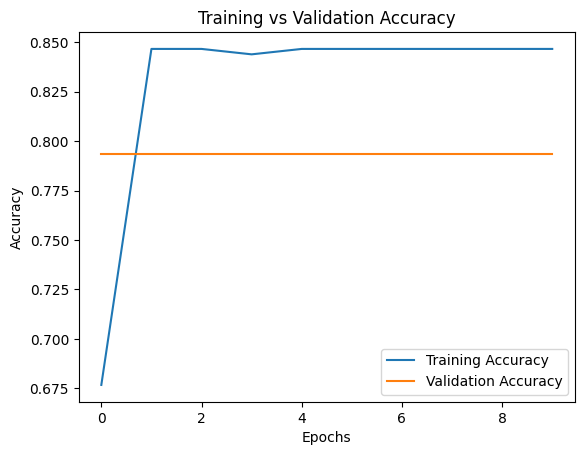

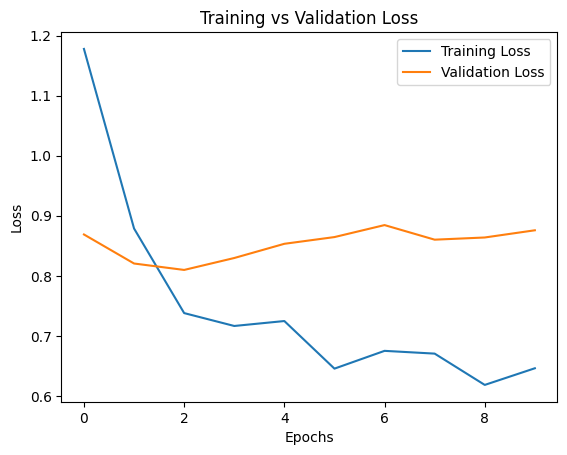

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


In [15]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8108 - loss: 0.8128 
Test Accuracy: 79.35%


In [17]:
def predict_sound(file_path):
    features = extract_features(file_path)
    
    features = np.mean(features, axis=0)
    
    features = np.expand_dims(features, axis=0)
    
    prediction = model.predict(features)
    
    predicted_label_idx = np.argmax(prediction)
    
    predicted_label = list(label_to_index.keys())[list(label_to_index.values()).index(predicted_label_idx)]
    
    return predicted_label

file_path = "/Users/ashutoshsrivastava/Desktop/DL project/donateacry_corpus/hungry/jkl69.wav"
predicted_class = predict_sound(file_path)
print(f"Predicted class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted class: hungry


In [19]:
model.save('baby_cry_classification_model.keras')
